# Лабораторная работа 2: Продвинутые методы безусловной оптимизации.

## Imports

In [1]:
from optimization import *
from oracles import *
from plot_trajectory_2d import *
from utils import *
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from sklearn import datasets
np.random.seed(42)
import os

## Experiment 1

In [2]:
np.random.seed(42)
seeds = np.random.randint(1, 30000, 5)

In [3]:
n_dim = [10, 100, 1000, 10000, 100000]
colors = ['r', 'g', 'b', 'm', 'y']
labels = ['n = 10', 'n = 100', 'n = 1000', 'n = 10000', 'n = 100000']
options = list(zip(n_dim, colors, labels))
cond_numbers = np.arange(1, 1001, 50)

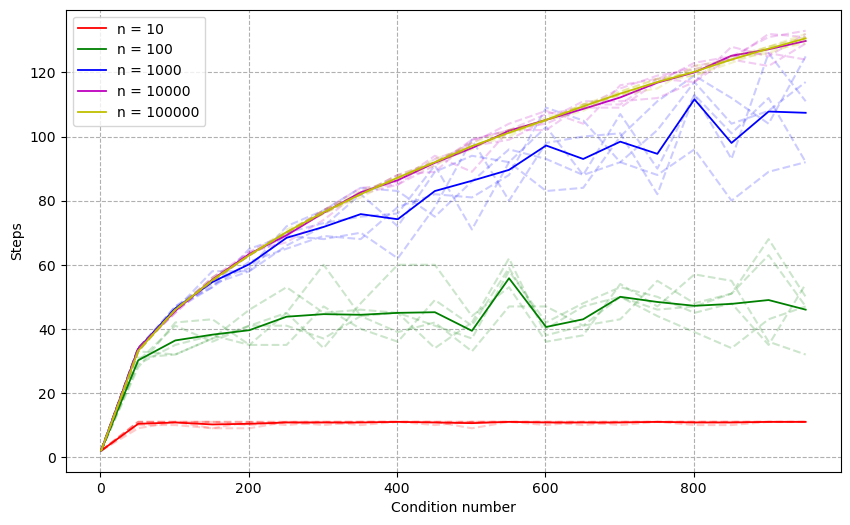

In [4]:
fig = plt.figure(figsize=(10, 6))
plt.xlabel('Condition number')
plt.ylabel('Steps')
plt.grid(linestyle='--')

for n, color, label in options: # для каждой размерности пространства n
    y = np.zeros(len(cond_numbers))
    for seed in seeds: # для каждого случайного построения
        np.random.seed(seed)
        y_curr = []
        for c in cond_numbers: # для каждого числа обусловленности
            diag = np.random.uniform(1, c, size=n)
            diag[0] = 1
            diag[-1] = c
            A, b = scipy.sparse.diags(diag, 0), np.random.rand(n)
            _, ms, history = conjugate_gradients(lambda x: A @ x, b, np.zeros(n),trace=True)
            y_curr.append(len(history['time']))

        y += np.array(y_curr)
        plt.plot(cond_numbers, y_curr, color + '--', alpha=0.2)

    plt.plot(cond_numbers, y / (1. * len(seeds)), color, linewidth=1.3, label=label)
    
plt.legend(loc='best')
plt.savefig('experiment_1/experiment_1.png')

## Experiment 2

In [37]:
from sklearn import datasets
import numpy as np

def read_data(f):
    data = datasets.load_svmlight_file(f)
    return data[0], data[1]

def plot(xlabel, data):
    fig = plt.figure(figsize=(10, 6))
    plt.xlabel(xlabel)
    plt.ylabel(r'$\log  \| \nabla f(x_k) \|_2^2 / \| \nabla f(x_0) \|_2^2$')
    
    for y, history, label in data:
        x = np.arange(len(y)) if xlabel == 'Iterations' else history['time']
        plt.plot(x, y, label=label)
    
    plt.legend()
    plt.grid(linestyle='--')
    plt.savefig(f'experiment_2/experiment_2_{xlabel}.png')
    plt.show()

In [38]:
X, y = read_data('gisette_scale.bz2')

Memory size: 0, iterations exceeded, iterations: 501, time: 252.800696
Memory size: 1, success, iterations: 75, time: 32.237946
Memory size: 5, success, iterations: 36, time: 13.760389
Memory size: 10, success, iterations: 33, time: 12.541683
Memory size: 50, success, iterations: 32, time: 12.065252
Memory size: 100, success, iterations: 32, time: 12.035525


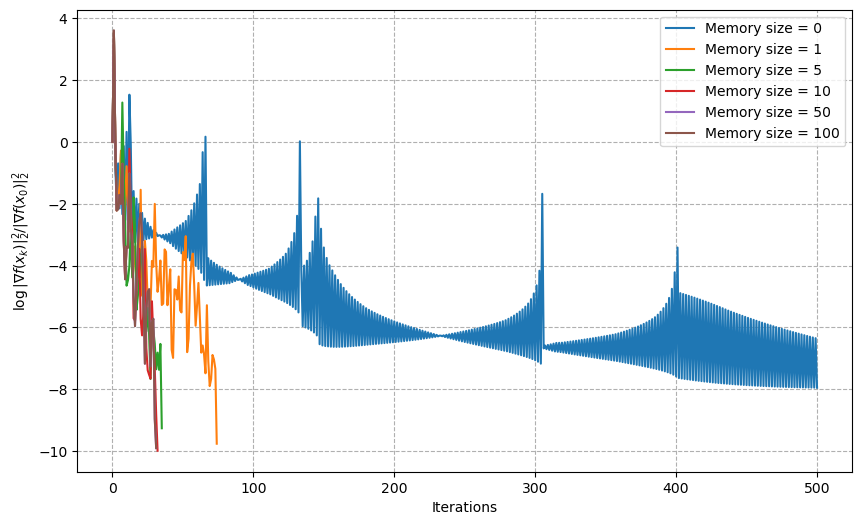

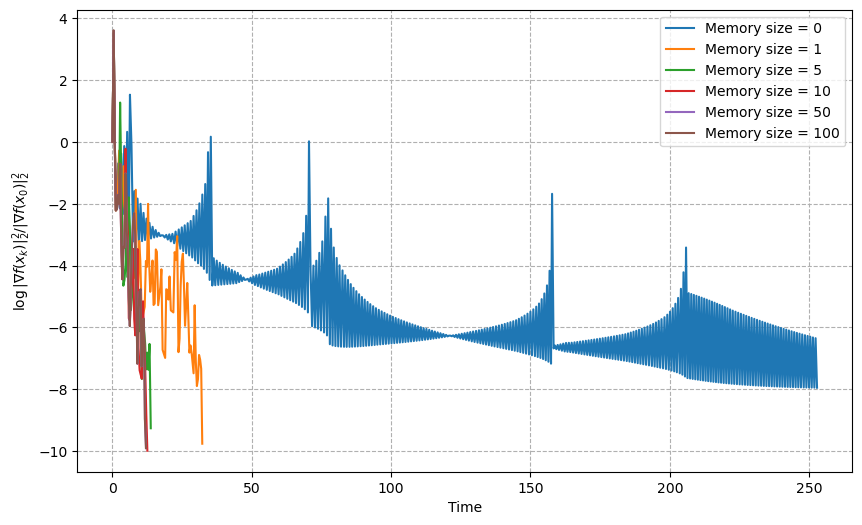

In [39]:
history_len = [0, 1, 5, 10, 50, 100]
labels = ['Memory size = 0', 'Memory size = 1', 'Memory size = 5', 'Memory size = 10', 'Memory size = 50', 'Memory size = 100']

regcoef = 1.0 / X.shape[0]
x_0 = np.zeros(X.shape[1])
oracle = create_log_reg_oracle(X, y, regcoef)
result = []

for memory_size, label in zip(history_len, labels):
    _, msg, history = lbfgs(oracle, x_0, memory_size=memory_size, trace=True)
    y = np.square(np.array(history['grad_norm'], copy=True))
    y = np.log(y / y[0])
    result.append((y, history, label))
    print(f'Memory size: {memory_size}, {msg}, iterations: {len(y)}, time: {history["time"][-1]}')
    
plot('Iterations', result)
plot('Time', result)

## Experiment 3

In [50]:
def experiment_3(file_name, dataset_name):
    
    def read_data(f):
        data = datasets.load_svmlight_file(f)
        return data[0], data[1]
    
    def plot(history_GD, history_HFN, history_LBFGS, ylabel, xlabel, dataset_name):
        
        def get_y(y, flaq):
            if flaq == 'func':
                return y
            y = np.square(np.array(y, copy=True))
            return np.log(y / y[0])
        
        def get_t(time, flaq):
            if flaq == 'iterations':
                return np.arange(len(time))
            return time
        
        y_gd, t_gd = get_y(history_GD[ylabel], ylabel), get_t(history_GD['time'], xlabel)
        y_hfn, t_hfn = get_y(history_HFN[ylabel], ylabel), get_t(history_HFN['time'], xlabel)
        y_lbfgs, t_lbfgs = get_y(history_LBFGS[ylabel], ylabel), get_t(history_LBFGS['time'], xlabel)

        fig = plt.figure()
        plt.xlabel(xlabel)
        ylab = 'Function value' if ylabel == 'func' else r'$\log  \| \nabla f(x_k) \|_2^2 / \| \nabla f(x_0) \|_2^2$'
        plt.ylabel(ylab)
        plt.plot(t_gd, y_gd, label='Gradient Descent')
        plt.plot(t_hfn, y_hfn, label='Hessian Free Newton')
        plt.plot(t_lbfgs, y_lbfgs, label='L-BFGS')
        plt.legend()
        plt.grid(linestyle='--')
        plt.savefig(f'experiment_3/{dataset_name}-{ylabel}-{xlabel}')
    
    print(F'DATASET: {dataset_name}\n')
    
    X, y = read_data(file_name)
    m, n = X.shape
    regcoef = 1.0 / m
    oracle = create_log_reg_oracle(X, y, regcoef)
    history_HFN, history_LBFGS, history_GD = None, None, None
    
    # Gradient descent
    print('Running gradient descent')
    _, res_GD, history_GD = gradient_descent(oracle,np.zeros(n), trace=True)
    print(f'Gradient descent is done, result is: {res_GD}, iters: {len(history_GD["time"])}, time: {history_GD["time"][-1]}, {round(history_GD["time"][-1] / len(history_GD["time"]), 3)}\n')
    
    # Hessian Free Newton
    print('Running Hessian Free Newton')
    _, res_HFN, history_HFN = hessian_free_newton(oracle, np.zeros(n), trace=True)
    print(f'Hessian Free Newton method is done, result is: {res_HFN}, iters: {len(history_HFN["time"])}, time: {history_HFN["time"][-1]}, {round(history_HFN["time"][-1] / len(history_HFN["time"]), 3)}\n')
    
    # L-BFGS
    print('Running L-BFGS')
    _, res_LBFGS, history_LBFGS = lbfgs(oracle, np.zeros(n), trace=True)
    print(f'L-BFGS method is done, result is: {res_LBFGS}, iters: {len(history_LBFGS["time"])}, time: {history_LBFGS["time"][-1]}, {round(history_LBFGS["time"][-1] / len(history_LBFGS["time"]), 3)}\n')
    
    plot(history_GD, history_HFN, history_LBFGS, 'func', 'iterations', dataset_name)
    plot(history_GD, history_HFN, history_LBFGS, 'func', 'time', dataset_name)
    plot(history_GD, history_HFN, history_LBFGS, 'grad_norm', 'time', dataset_name)

In [51]:
dataset_name = os.listdir('datasets/')
dataset_name = dataset_name[:-1]
dataset_name

['w8a.txt', 'real-sim.bz2', 'news20.bz2', 'gisette_scale.bz2', 'rcv1.bz2']

DATASET: w8a

Running gradient descent
Gradient descent is done, result is: success, iters: 36, time: 1.234681, 0.034

Running Hessian Free Newton
Hessian Free Newton method is done, result is: success, iters: 7, time: 0.165139, 0.024

Running L-BFGS
L-BFGS method is done, result is: success, iters: 9, time: 0.108291, 0.012

DATASET: real-sim

Running gradient descent
Gradient descent is done, result is: success, iters: 104, time: 30.817768, 0.296

Running Hessian Free Newton
Hessian Free Newton method is done, result is: success, iters: 5, time: 0.919046, 0.184

Running L-BFGS
L-BFGS method is done, result is: success, iters: 10, time: 0.806277, 0.081

DATASET: news20

Running gradient descent
Gradient descent is done, result is: success, iters: 153, time: 206.55245, 1.35

Running Hessian Free Newton
Hessian Free Newton method is done, result is: success, iters: 4, time: 3.996799, 0.999

Running L-BFGS
L-BFGS method is done, result is: success, iters: 14, time: 6.756792, 0.483

DATASE

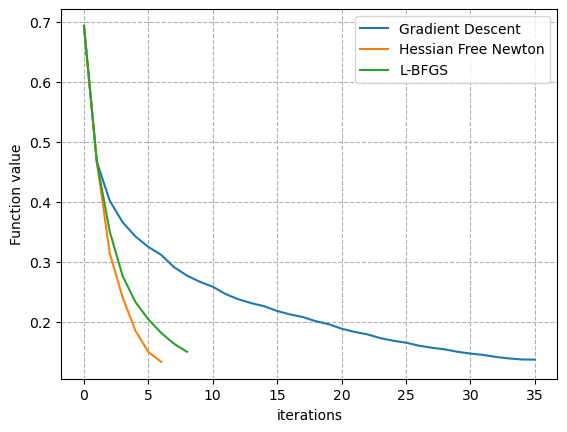

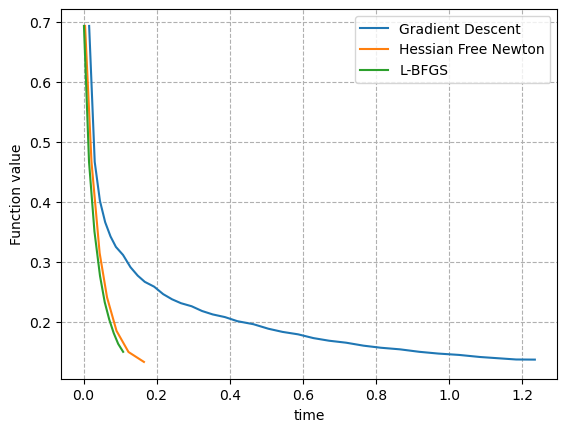

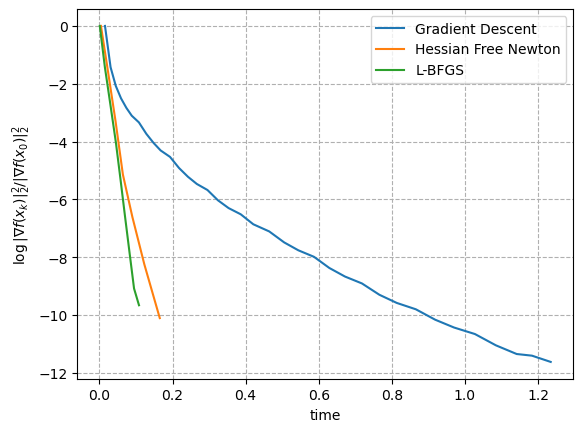

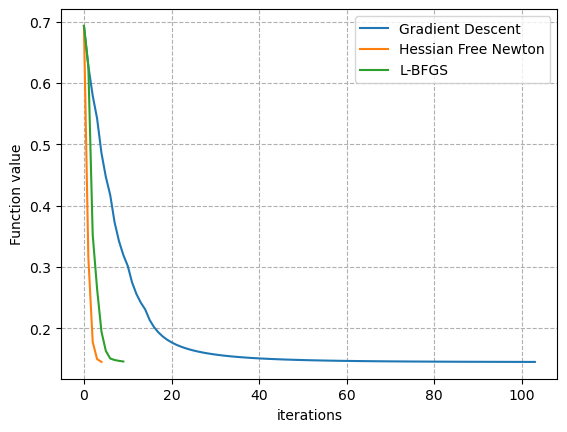

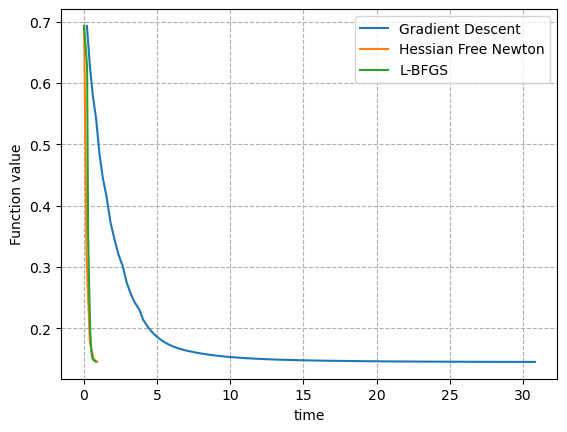

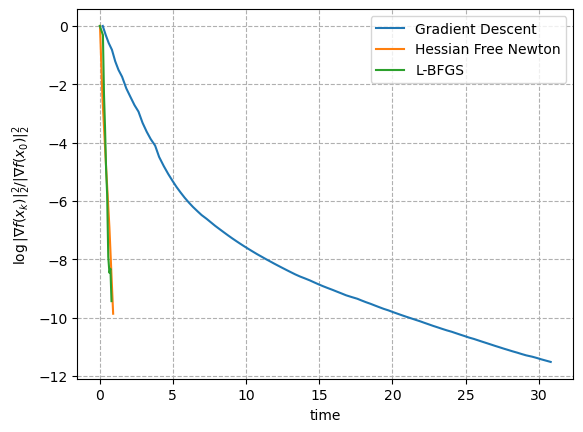

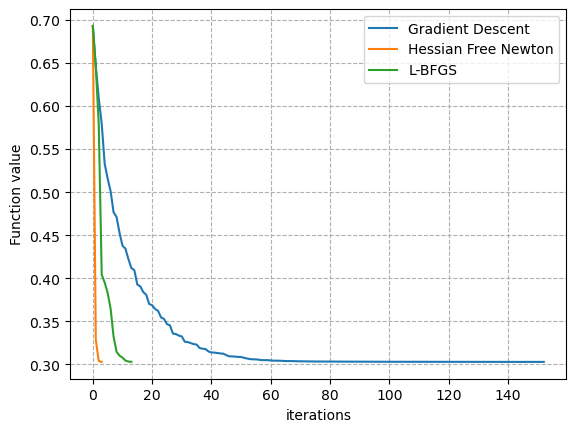

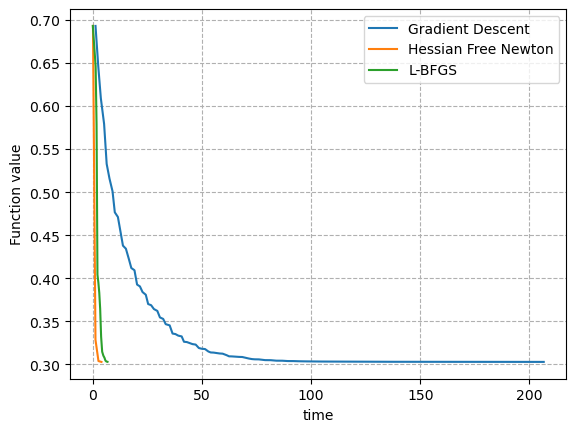

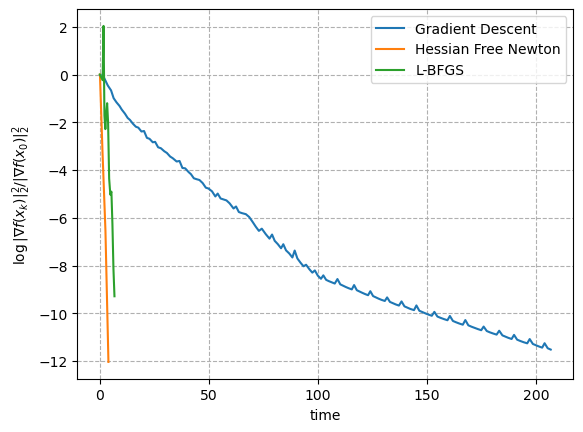

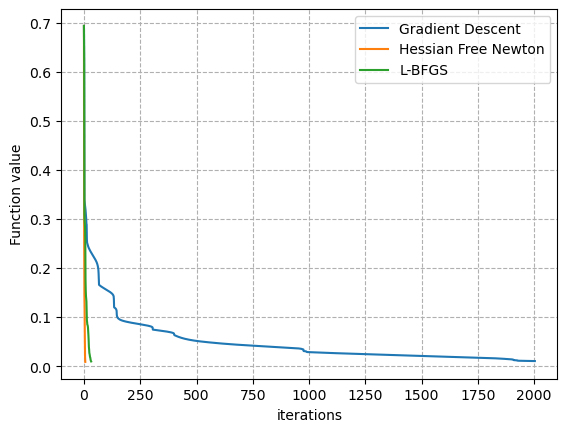

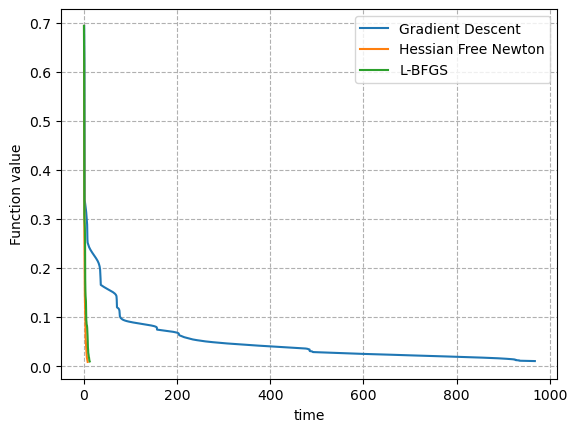

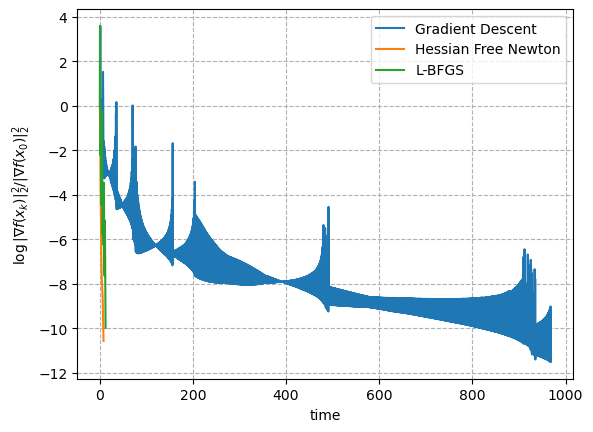

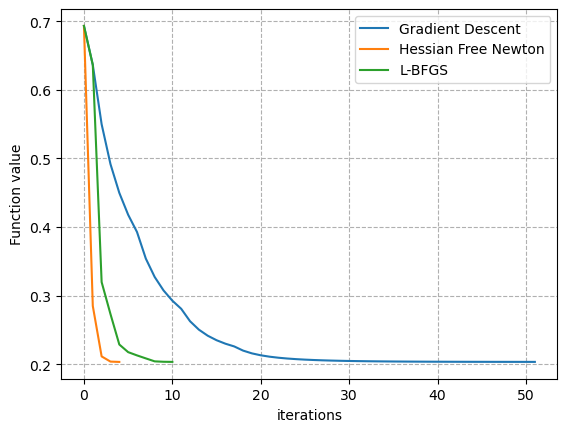

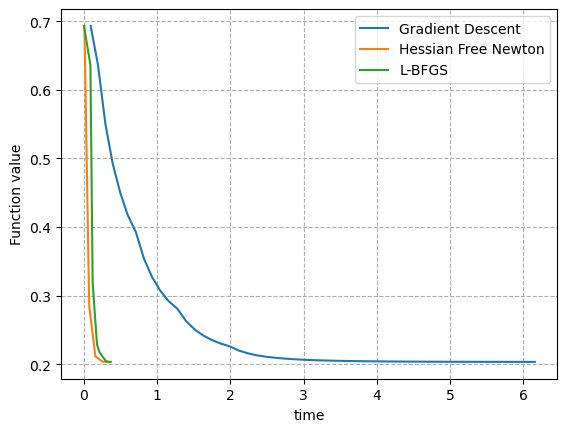

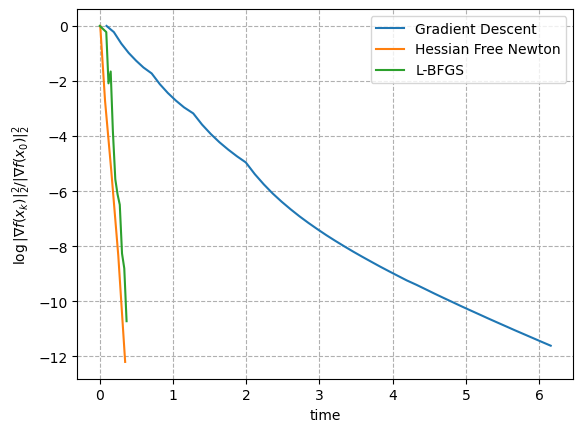

In [52]:
for name in dataset_name:
    experiment_3('datasets/' + name, name[:-4])